In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn
from os.path import join
%matplotlib inline

In [94]:
from PRmm.extras.hqrfHmm import loadBazViewerHDF5
from PRmm.model import Fixture

fxBL   = Fixture.fromIniFile("/home/UNIXHOME/dalexander/Projects/Bugs/Dromedary-HQRF/Ecoli-7799/fixtures.ini", "Baseline")
dfBL   = loadBazViewerHDF5("/tmp/baseline_metrics.h5")

fxX1E3 = Fixture.fromIniFile("/home/UNIXHOME/dalexander/Projects/Bugs/Dromedary-HQRF/Ecoli-7799/fixtures.ini", "X1E3")
dfX1E3 = loadBazViewerHDF5("/tmp/X1E3_metrics.h5")

In [100]:
def basicActivityPlot(df, hn, fx=None, label=""):
    fig, axs = plt.subplots(3, 1, sharey=True, figsize=(6,10))
            
    dfZ = df[df.ZmwNumber==hn].copy()
    dfZ["BASE_END"] = dfZ.NUM_BASES.cumsum()
    
    def calculateRegions(fxZ):
        hasAlignments = len(fxZ.alignments) > 0
        hasHqRegion = len(fxZ.baseRegions.hqRegion) > 0       

        # Resolve a (begin,end) extent in bases to an extent in windows,
        # using BASE_END
        def resolveBaseExtent(baseExtent):
            b, e = baseExtent
            return (dfZ.BASE_END.searchsorted(b), 
                    dfZ.BASE_END.searchsorted(e))

        if hasHqRegion:
            hqExtent = resolveBaseExtent(fxZ.baseRegions.hqRegion.extent)
        else:
            hqExtent = None

        if hasAlignments:
            alnExtents = [ resolveBaseExtent(aln.extent)
                           for aln in fxZ.baseRegions.alignments ]
        else:
            alnExtents = []
        
        return (hqExtent, alnExtents)
    
    
    def makeSubplot(row, metric, desc, regions=None):
        plt.subplot(3, 1, row + 1)
        plt.plot(dfZ.BlockNumber, metric, 'o', alpha=0.6)
        ax = plt.gca()
        ax.set_xlim(0, len(dfZ))
        ymin, ymax = ax.get_ylim()
        
        if regions:
            hqExtent, alnExtents = regions
            for alnExtent in alnExtents:
                plt.hlines(ymax, alnExtent[0], alnExtent[1], linewidth=16, color="red")
            if hqExtent:
                plt.hlines(ymin, hqExtent[0],  hqExtent[1],  linewidth=16, color="black")
                
        plt.ylabel(desc)
    
    if fx:
        fxZ = fx[hn]
        regions = calculateRegions(fxZ)
    else:
        fxZ = None
        regions = None

    makeSubplot(0, dfZ.LabelStutterRate, "Pulse homopolymer content", regions)
    makeSubplot(1, dfZ.PulseRate,        "Pulse rate",                regions)
    makeSubplot(2, dfZ.HalfSandwichRate, "Half-sandwich rate",        regions)
            
    if fxZ is None:
        title = str(hn)
    else:
        title = fxZ.zmwName
        
    if fxZ.hasAlignments:
        title += "\nAlns: "
        title += ", ".join("%dbp @ %.1f%% " % (aln.readLength, 100*aln.identity)
                           for aln in fxZ.alignments)
        
    fig.suptitle(title, size=16)


[ 12.98731232   8.42477226  12.96691132   6.63025379]


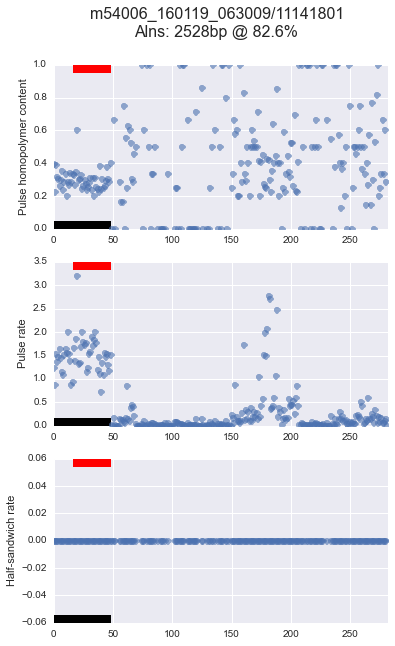

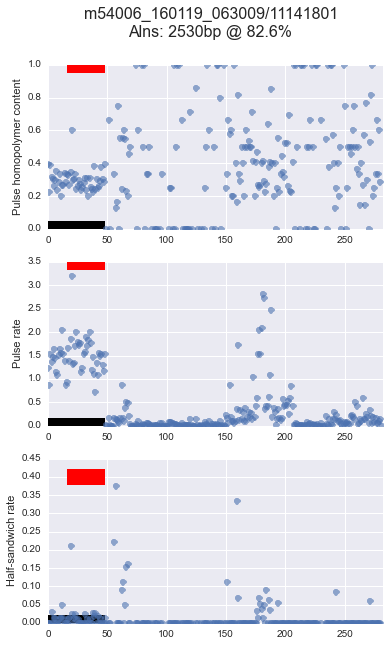

In [104]:
from ipywidgets import *

def plotMetricsP(hnString):
    hn = int(hnString)
    basicActivityPlot(dfBL,   hn, fxBL, label="Baseline")
    basicActivityPlot(dfX1E3, hn, fxX1E3, label="X1E3")

    print fxX1E3[hn].hqRegionSnr

# Let's look at hns with HQR but no alignment.

hnsOfInterest = [hn for hn in fxX1E3.holeNumbers[:500]
                 if min(fxX1E3.basF[hn].hqRegionSnr) >= 5]

hnW = Select(options=map(str, hnsOfInterest))

interact(plotMetricsP, hnString=hnW)

In [ ]:
def z():
    return fx[int(hnW.selected_label)]

In [ ]:
for aln in z().alignments:
    print aln.identity

In [ ]:
z().hqRegionSnr

0.813446969697


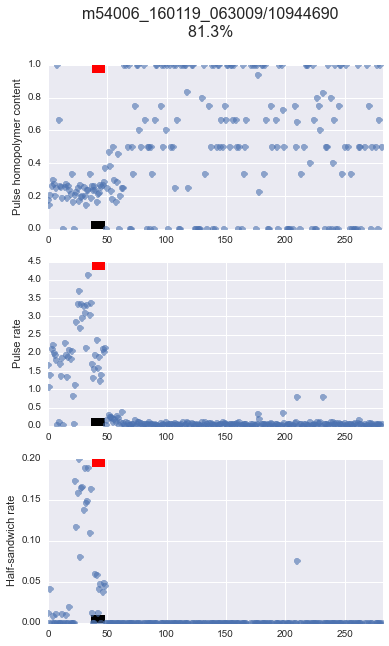

In [91]:
basicActivityPlot(df, hn, fxX1E3)

In [54]:
axs[1]